# Evaluating Latent Representations

In this notebook we explore 2 questions. (i) Are there any clear tradeoffs between predictivity, smoothness, and disentanglement when creating a latent space? (ii) How does varying the dataset affect our conclusions? To answer this questions, we evaluate pre-determined metrics for each mentioned property in different latent methods for 10 datasets. The datasets were created by randomly applying non-linear functions to Gaussian white noise.

In [1]:
from sklearn.decomposition import FactorAnalysis, PCA, FastICA
from sklearn.manifold import LocallyLinearEmbedding

# Constants to be used in our code
H_SIZE, X_SIZE, Z_SIZE, N_DATASETS = 2, 4, 2, 10

# List of variables for h, x, and z
h_variables = [f'h_{i}' for i in range(H_SIZE)]
x_variables = [f'x_{i}' for i in range(X_SIZE)]
z_variables = [f'z_{i}' for i in range(Z_SIZE)]

# List of latent methods we are using
methods = [FactorAnalysis, PCA, FastICA, LocallyLinearEmbedding]

# Get latent representations for a given method
def create_latent_space(df, latent_method):
    latent = latent_method(n_components=Z_SIZE, random_state=0).fit_transform(df[x_variables])
    latent = pd.DataFrame(latent, columns=z_variables)
    latent = pd.concat([df, latent], axis=1)
    return latent

# Create dataframes for each method
def get_latent_spaces(df, latent_methods):
    latent_spaces = []
    for latent_method in latent_methods:
        latent = create_latent_space(df, latent_method)
        latent_spaces.append(latent)
    return latent_spaces

## Latent Representations and Metrics

We start off by producing 4 different latent representations based on linear and manifold methods. We then apply the 3 metrics described by Tomas to describe predictivity, smoothness, and disentanglement. Their implementation is shown in the file 'metrics.py'.

In [2]:
import pandas as pd
from representation_learning.metrics import multiple_correlation, mutual_information_gap, inverted_kruskals_stress

# Each list will store the results of a method
results = [[[], [], []] for i in range(len(methods))]

# The biggest iteration is going over each dataset
for dataset_i in range(N_DATASETS):

    # Load the dataset and get the latent spaces
    data = pd.read_csv(f'datasets/random_data_{dataset_i}.csv')
    fa, pca, ica, lle = get_latent_spaces(data, methods)

    # Get metrics for each method
    for index, latent_space in enumerate([fa, pca, ica, lle]):
        results[index][0].append(multiple_correlation(latent_space, 'y', z_variables))
        results[index][1].append(inverted_kruskals_stress(latent_space, x_variables, z_variables, 0.01, silent=True))
        results[index][2].append(mutual_information_gap(latent_space, h_variables, z_variables))

    print(f'Done dataset {dataset_i}')

Done dataset 0
Done dataset 1
Done dataset 2
Done dataset 3


/Users/fernandoassad/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Done dataset 4
Done dataset 5
Done dataset 6
Done dataset 7
Done dataset 8
Done dataset 9


## Understanding Results

It seems from our figure (see below) that there is no obvious tradeoff between the properties. On the other hand, a more interesting result is that the dataset selected has a huge effect on the value of the metric. Hence, utilizing multiple datasets to evaluate the properties of a technique to create latent spaces is crucial. Further, different techniques can be better or worse than others depending on the dataset (see the second figure).

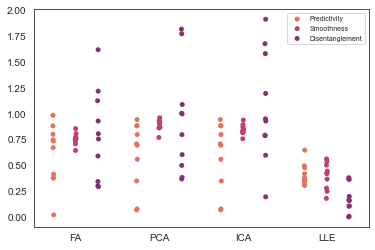

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Organize the data in a way it can be plotted
processed_data = [results[i][j][k] for i in range(4) for j in range(3) for k in range(10)]
metric_n = [j for i in range(4) for j in range(3) for k in range(10)]
latent_n = [i for i in range(4) for j in range(3) for k in range(10)]
dataset_n = [k for i in range(4) for j in range(3) for k in range(10)]

# Plot a strip plot
sns.set_style('white')
sns.stripplot(x=latent_n, y=processed_data, hue=metric_n, jitter=0.02, dodge=True, palette='flare')
plt.xticks([0, 1, 2, 3], ['FA', 'PCA', 'ICA', 'LLE'])
plt.legend(['Predictivity', 'Smoothness', 'Disentanglement'], frameon=True, loc=1, fontsize='x-small')
plt.savefig('figures/latent_strip_plot.png', dpi=250)
plt.show()

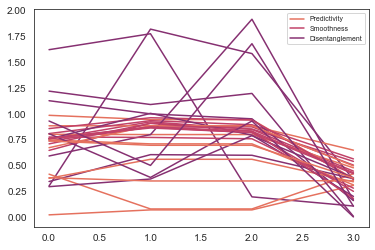

In [4]:
colors = sns.color_palette('flare', 3)

# Create lines that check variation per dataset
predictivity_lines = [[processed_data[i] for i in range(initial, initial + 120, 30)] for initial in range(0, 10)]
smoothness_lines = [[processed_data[i] for i in range(initial, initial + 120, 30)] for initial in range(10, 20)]
disentanglement_lines = [[processed_data[i] for i in range(initial, initial + 120, 30)] for initial in range(20, 30)]
latent_lines = [[latent_n[i] for i in range(initial, initial + 120, 30)] for initial in range(10)]

for i in range(10):
    sns.lineplot(x=latent_lines[i], y=predictivity_lines[i], color=colors[0])
    sns.lineplot(x=latent_lines[i], y=smoothness_lines[i], color=colors[1])
    sns.lineplot(x=latent_lines[i], y=disentanglement_lines[i], color=colors[2])

plt.legend(['Predictivity', 'Smoothness', 'Disentanglement'], frameon=True, loc=1, fontsize='x-small')

plt.savefig('figures/dataset_variation.png', dpi=250)
plt.show()